In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)
np.random.seed(0)

In [3]:
from replay_identification.simulate import make_simulated_data

(is_replay, speed, linear_distance, power, spikes, time, multiunit) = make_simulated_data()

INFO:numexpr.utils:Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.0006666666666666666,
           detrend_type='constant', start_time=0, n_tapers=1)


In [4]:
from replay_identification import ReplayDetector

r = ReplayDetector(replay_speed=1, movement_var=4.0, place_bin_size=2.0, spike_model_knot_spacing=15,
                   spike_model_penalty=0.5, movement_state_transition_type='random_walk',
                   discrete_state_transition_type='ripples_with_speed_threshold', multiunit_model_kwargs={'mark_std': 24.0, 'position_std': 6.0, 'block_size': 100})
r.fit(is_replay, speed, linear_distance, power, spikes, multiunit, use_gpu=True)

INFO:replay_identification.decoders:Fitting speed model...
INFO:replay_identification.decoders:Fitting LFP power model...
INFO:replay_identification.decoders:Fitting spiking model...
INFO:replay_identification.decoders:Fitting multiunit model...
INFO:replay_identification.decoders:Fitting replay movement state transition...
INFO:replay_identification.decoders:Fitting replay state transition...


ReplayDetector(discrete_diagonal=None,
               discrete_state_transition_type='ripples_with_speed_threshold',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='random_walk', movement_var=4.0...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 24.0,
                                       'position_std': 6.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.0, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05, speed_knots=None,
               speed_threshold=4.0, spike_model_knot_spacing=15,
 

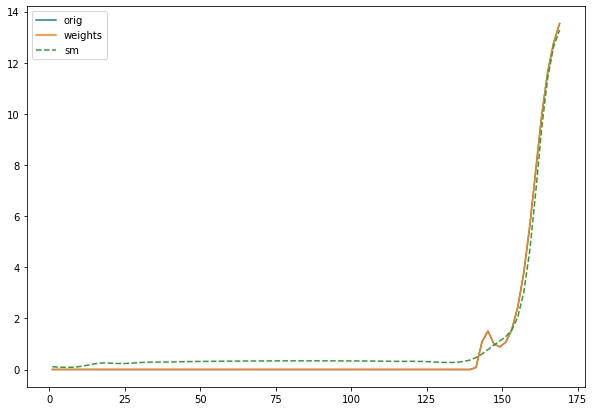

In [126]:
import statsmodels.api as sm
from statsmodels.api import families
from replay_identification.spiking_likelihood import make_spline_design_matrix, make_spline_predict_matrix, get_firing_rate
from regularized_glm import penalized_IRLS


def predict_weights(linear_distance, spikes, is_training, plot_sm=False, label=''):
    # position = linear_distance[:, np.newaxis].copy()
    # spikes = spikes.copy()
    
    position = linear_distance[:, np.newaxis]
    
    # is_training = np.asarray(is_training).astype(float)
    # include = ~np.isclose(is_training, 0.0) & ~np.any(
    #     np.isnan(position), axis=1)
    # is_training = is_training[include]
    # position = position[include]
    # spikes = spikes[include]
    
    place_bin_edges = r.place_bin_edges_
    knot_spacing = 7.5
    spike_ind = 7
    penalty = 1E-5
    tolerance = 1E-5
    place_bin_centers = r.place_bin_centers_

    design_matrix = make_spline_design_matrix(
        position, place_bin_edges, knot_spacing)
    
    penalty = np.ones((design_matrix.shape[1],)) * penalty
    penalty[0] = 0.0
    
    if not plot_sm:
        result = penalized_IRLS(
                design_matrix,
                spikes[:, spike_ind],
                family=families.Poisson(),
                penalty=penalty,
                tolerance=tolerance,
                prior_weights=is_training)
        place_field_coefficients = result.coefficients[:, np.newaxis]
        predict_matrix = make_spline_predict_matrix(
            design_matrix.design_info, place_bin_centers)
        place_conditional_intensity = get_firing_rate(
            predict_matrix, place_field_coefficients, sampling_frequency=1000)
        plt.plot(place_bin_centers, place_conditional_intensity, label=label)
    else:
        predict_matrix = make_spline_predict_matrix(
            design_matrix.design_info, place_bin_centers)
        sm_glm = sm.GLM(
            spikes[:, spike_ind],
            design_matrix,
            family=families.Poisson(),
            var_weights=is_training
        ).fit_regularized(
                alpha=penalty,
                maxiter=25,
                L1_wt=0,
                cnvrg_tol=tolerance)
        # sm_glm = sm.GLM(
        #     spikes[:, spike_ind],
        #     design_matrix,
        #     family=families.Poisson(),
        #     var_weights=is_training
        # ).fit(maxiter=25,
        #       cnvrg_tol=tolerance)
        place_conditional_intensity = get_firing_rate(
            predict_matrix, sm_glm.params, sampling_frequency=1000)
        plt.plot(place_bin_centers, place_conditional_intensity, label='sm', linestyle='--')
    

plt.figure(figsize=(10, 7))
is_training = np.ones_like(linear_distance, dtype=float)
predict_weights(linear_distance, spikes, is_training, label='orig')
is_training = np.ones_like(linear_distance, dtype=float)
is_training[(linear_distance > 10) & (linear_distance < 20)] = 1.0
predict_weights(linear_distance, spikes, is_training, label='weights')

predict_weights(linear_distance, spikes, is_training, plot_sm=True)
plt.legend()

In [107]:
sm.GLM?

Init signature:
sm.GLM(
    endog,
    exog,
    family=None,
    offset=None,
    exposure=None,
    freq_weights=None,
    var_weights=None,
    missing='none',
    **kwargs,
)
Docstring:     
Generalized Linear Models

GLM inherits from statsmodels.base.model.LikelihoodModel

Parameters
----------
endog : array_like
    1d array of endogenous response variable.  This array can be 1d or 2d.
    Binomial family models accept a 2d array with two columns. If
    supplied, each observation is expected to be [success, failure].
exog : array_like
    A nobs x k array where `nobs` is the number of observations and `k`
    is the number of regressors. An intercept is not included by default
    and should be added by the user (models specified using a formula
    include an intercept by default). See `statsmodels.tools.add_constant`.
family : family class instance
    The default is Gaussian.  To specify the binomial distribution
    family = sm.family.Binomial()
    Each family can take a l

In [ ]:
def penalized_IRLS(design_matrix, response, sqrt_penalty_matrix=None,
                   penalty=_EPS, family=families.Gaussian(),
                   max_iterations=25, prior_weights=None,
                   offset=None, tolerance=1E-8):
    '''Estimate coefficients and associated statistics of models in the
    exponential family.
    Parameters
    ----------
    design_matrix : ndarray, shape (n_observations, n_covariates)
    response : ndarray, shape (n_observations,)
    sqrt_penalty_matrix : ndarray, optional,
                          shape (n_observations, n_observations)
    penalty : ndarray, optional, shape (n_observations,)
    family : statsmodels.api.family instance, optional
    max_iterations : int, optional
    prior_weights : ndarray, optional, shape (n_observations,)
    offset : ndarray, optional, shape (n_observations,)
    tolerance : float, optional
    Returns
    -------
    coefficients : ndarray, shape (n_covariates,)
    is_converged : bool
    coefficient_covariance : ndarray, shape (n_covariates, n_covariates)
    aic : float
    deviance : float
    degrees_of_freedom : float
    scale : float
    '''
    if design_matrix.ndim < 2:
        design_matrix = design_matrix[:, np.newaxis]
    if response.ndim < 2:
        response = response[:, np.newaxis]

    n_observations, n_covariates = design_matrix.shape

    if prior_weights is None:
        prior_weights = np.ones_like(response)
    elif prior_weights.ndim < 2:
        prior_weights = prior_weights[:, np.newaxis]

    if offset is None:
        offset = np.zeros_like(response)

    if sqrt_penalty_matrix is None:
        sqrt_penalty_matrix = np.eye(n_covariates, dtype=design_matrix.dtype)

    is_converged = False

    predicted_response = family.starting_mu(response)
    linear_predictor = family.link(predicted_response)

    sqrt_penalty_matrix = np.sqrt(penalty) * sqrt_penalty_matrix

    augmented_weights = np.ones_like(response[:n_covariates])
    full_design_matrix = np.concatenate((design_matrix, sqrt_penalty_matrix))
    augmented_response = np.zeros_like(response[:n_covariates])
    coefficients = np.zeros((n_covariates,))

    for _ in range(max_iterations):
        link_derivative = family.link.deriv(predicted_response)
        pseudo_data = (linear_predictor + (response - predicted_response)
                       * link_derivative - offset)
        weights = prior_weights / (family.variance(predicted_response)
                                   * link_derivative ** 2)

        full_response = np.concatenate((pseudo_data, augmented_response))
        full_weights = np.concatenate((np.sqrt(weights), augmented_weights))

        coefficients_old = coefficients.copy()
        try:
            coefficients = np.linalg.lstsq(
                full_design_matrix * full_weights,
                full_response * full_weights, rcond=None)[0]
        except (np.linalg.LinAlgError, ValueError):
            logger.warn(
                'Weighted least squares failed. Returning NaN coefficiients.')
            coefficients *= np.nan
            break

        linear_predictor = offset + design_matrix @ coefficients
        predicted_response = family.link.inverse(linear_predictor)

        # use deviance change instead?
        coefficients_change = np.linalg.norm(coefficients - coefficients_old)
        if coefficients_change < tolerance:
            is_converged = True
            break

    U, singular_values, Vt = _weighted_design_matrix_svd(
        design_matrix, sqrt_penalty_matrix, weights)

    degrees_of_freedom = get_effective_degrees_of_freedom(U)
    scale, is_estimated_scale = estimate_scale(
        family, response, predicted_response, prior_weights,
        degrees_of_freedom)
    coefficient_covariance = get_coefficient_covariance(
        U, singular_values, Vt, scale)
    deviance = family.deviance(
        response, predicted_response, prior_weights, scale)
    log_likelihood = family.loglike(
        response, predicted_response, prior_weights, scale)
    aic = estimate_aic(log_likelihood, degrees_of_freedom)

    return Results(
        coefficients=np.squeeze(coefficients),
        is_converged=is_converged,
        coefficient_covariance=coefficient_covariance,
        log_likelihood=log_likelihood,
        AIC=aic,
        deviance=deviance,
        degrees_of_freedom=degrees_of_freedom,
        scale=scale
    )